In [206]:
from pulp import *
import numpy as np
import pandas as pd
import re 
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [207]:
#Read a file
data = pd.read_excel(r'C:\Users\jthekkel\Documents\Optimization\NurseOptimizationDetail.xlsx',sheet_name='Data')
print(data)

        Nurse  Pay  Quality  DayOff
0       Tracy   20        1       0
1       Sally   25       10       1
2      Marcus   20        2       1
3       Jacob   18        1       1
4       Daisy   19        5       1
5      Stella   20        1       0
6       Janet   20       10       1
7     Richard   22        6       1
8        Mark   20        7       0
9        Nina   21        3       0
10      Brian   21        3       1
11  Christina   20        3       1
12    Katrina   18       10       1


Pay = Hourly Pay

Quality = Score 1-10; 1 being the best

DayOff = 0 is off, 1 is available 

### Data Investigation

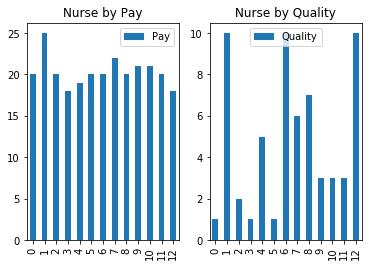

In [208]:
fig, axs = plt.subplots(1,2)
my_plot = data[['Nurse', 'Pay']].plot(kind='bar', title="Nurse by Pay", ax=axs[0])
my_plot = data[['Nurse', 'Quality']].plot(kind='bar', title="Nurse by Quality", ax=axs[1])

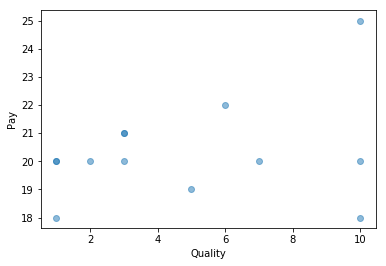

In [209]:
y = data.Pay
x = data.Quality

plt.scatter(x,y, alpha=0.5)
plt.ylabel('Pay')
plt.xlabel('Quality')
plt.show()

### Create Problem

In [210]:
#We want to minimize the cost
prob = pulp.LpProblem('ScheduleNurse',pulp.LpMinimize)

### Decision Variables 

In [211]:
decision_variables = []
for rownum, row in data.iterrows(): #loop through each row
	variable = str('x' + str(rownum)) #add x to each rownum
	variable = pulp.LpVariable(str(variable), lowBound = 0, upBound = 1, cat= 'Integer') #make variables binary
	decision_variables.append(variable)

print ("Total number of decision_variables: " + str(len(decision_variables)))
print ("Array with Decision Variables:" + str(decision_variables))

Total number of decision_variables: 13
Array with Decision Variables:[x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12]


### Objective Function

In [212]:
total_cost = ""
for rownum, row in data.iterrows():
	for i, schedule in enumerate(decision_variables):
		if rownum == i:
			formula = row['Pay']*row['Quality']*row['DayOff']*schedule
			total_cost += formula

prob += total_cost
print ("Optimization function: " + str(total_cost))

Optimization function: 250*x1 + 63*x10 + 60*x11 + 180*x12 + 40*x2 + 18*x3 + 95*x4 + 200*x6 + 132*x7


### Constaints 

In [213]:
#Constraint 1
Nurses_per_shift = 2
total_Nurses = ""
for rownum, row in data.iterrows():
	for i, schedule in enumerate(decision_variables):
		if rownum == i:
			formula = schedule
			total_Nurses += formula

prob += (total_Nurses == Nurses_per_shift)

In [214]:
#Constraint 2
DayOff = ""
for rownum, row in data.iterrows():
	for i, schedule in enumerate(decision_variables):
		if rownum == i:
			formula = row['DayOff']*schedule
			DayOff += formula

prob += (DayOff == 2)

### Print Problem Statement

In [215]:
print prob
prob.writeLP("ScheduleNurses.lp" )

ScheduleNurse:
MINIMIZE
250*x1 + 63*x10 + 60*x11 + 180*x12 + 40*x2 + 18*x3 + 95*x4 + 200*x6 + 132*x7 + 0
SUBJECT TO
_C1: x0 + x1 + x10 + x11 + x12 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 = 2

_C2: x1 + x10 + x11 + x12 + x2 + x3 + x4 + x6 + x7 = 2

VARIABLES
0 <= x0 <= 1 Integer
0 <= x1 <= 1 Integer
0 <= x10 <= 1 Integer
0 <= x11 <= 1 Integer
0 <= x12 <= 1 Integer
0 <= x2 <= 1 Integer
0 <= x3 <= 1 Integer
0 <= x4 <= 1 Integer
0 <= x5 <= 1 Integer
0 <= x6 <= 1 Integer
0 <= x7 <= 1 Integer
0 <= x8 <= 1 Integer
0 <= x9 <= 1 Integer



### Execute Optimizer 

In [216]:
optimization_result = prob.solve()

assert optimization_result == pulp.LpStatusOptimal
print("Status:", LpStatus[prob.status])
print("Optimal Solution to the problem: ", value(prob.objective))
print ("Individual decision_variables: ")
for v in prob.variables():
	print(v.name, "=", v.varValue)

('Status:', 'Optimal')
('Optimal Solution to the problem: ', 58.0)
Individual decision_variables: 
('x0', '=', 0.0)
('x1', '=', 0.0)
('x10', '=', 0.0)
('x11', '=', 0.0)
('x12', '=', 0.0)
('x2', '=', 1.0)
('x3', '=', 1.0)
('x4', '=', 0.0)
('x5', '=', 0.0)
('x6', '=', 0.0)
('x7', '=', 0.0)
('x8', '=', 0.0)
('x9', '=', 0.0)


### Display Output

In [217]:
variable_name = []
variable_value = []

for v in prob.variables():
	variable_name.append(v.name)
	variable_value.append(v.varValue)

df = pd.DataFrame({'variable': variable_name, 'value': variable_value})
for rownum, row in df.iterrows():
	value = re.findall(r'(\d+)', row['variable'])
	df.loc[rownum, 'variable'] = int(value[0])

df = df.sort_index(by='variable')

#append results
for rownum, row in data.iterrows():
	for results_rownum, results_row in df.iterrows():
		if rownum == results_row['variable']:
			data.loc[rownum, 'decision'] = results_row['value']
            
data[:]

C:\Users\jthekkel\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  del sys.path[0]


,Nurse,Pay,Quality,DayOff,decision
0,Tracy,20,1,0,0.0
1,Sally,25,10,1,0.0
2,Marcus,20,2,1,1.0
3,Jacob,18,1,1,1.0
4,Daisy,19,5,1,0.0
5,Stella,20,1,0,0.0
6,Janet,20,10,1,0.0
7,Richard,22,6,1,0.0
8,Mark,20,7,0,0.0
9,Nina,21,3,0,0.0
